In [3]:
# computation
import numpy as np
import tensorflow as tf
import prettytensor as pt

# utility funcs
from numpy.random import normal,random_sample
from datetime import datetime
from scipy.stats import norm

# visualization
import matplotlib.pyplot as plt
from IPython import display
from IPython.display import HTML
from matplotlib import animation
import seaborn as sns
%matplotlib inline

In [4]:
latent_size = 1
batch_size = 200
data_size = 1

# for Adam optimizer:
eta = 2e-4
beta1 = 0.5

# Data distribution $p_{data}$

$$
p_{data} = \mathcal{N}\bigg(1, 1\bigg)
$$

In [5]:
def gen_data(n_samples):
    """generate data according to p_data"""
    return normal(loc=1, scale=1, size=(n_samples,1))

def gen_noise(batch_size, latent_dim):
    """generate n_samples of random noise"""
    return random_sample((batch_size, latent_dim))

In [6]:
def viz_data(data):
    """Plot a scatterplot of the given data"""
    assert data.shape[1] == 1

    # plot p_data
    x = np.linspace(-3,5,1000)
    y = norm.pdf(x, loc=1, scale=1)    # for example
    p = plt.plot(x,y, label='p_data')

    # draw data
    sns.distplot(data, label='data', norm_hist=True)
    
    # draw decision boundary
    # TODO
    
    plt.legend()

In [7]:
data = gen_data(2000)

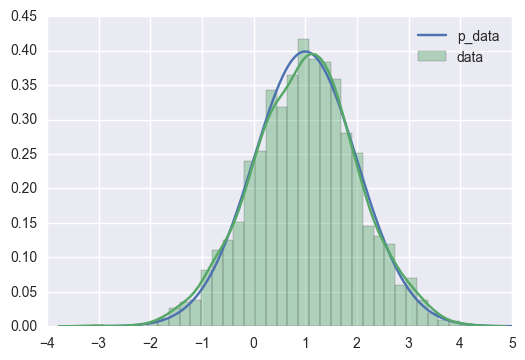

In [8]:
viz_data(data)

In [9]:
def generator(input_data):
    with pt.defaults_scope(activation_fn=tf.nn.tanh, variable_collections=['generator']):
        return (pt.wrap(input_data).flatten()
               .fully_connected(data_size)).tensor

In [10]:
def discriminator(input_data):
    with pt.defaults_scope(activation_fn=tf.nn.tanh, variable_collections=['discriminator']):
        return (pt.wrap(input_data).flatten()
               .fully_connected(2)
               .fully_connected(1, activation_fn=tf.nn.sigmoid)
               ).tensor

In [11]:
tf.reset_default_graph()
data_tensor = tf.placeholder(np.float32, shape=(batch_size, data_size))
noise_tensor = tf.placeholder(np.float32, shape=(batch_size, latent_size))


output_g = generator(noise_tensor)
output_d_real = discriminator(data_tensor)
output_d_fake = discriminator(output_g)

# discriminator loss (for both cases)
# max log(D(x)) + log(1 - D(z))
loss_d_real = -tf.reduce_mean(tf.log(output_d_real + 1e-12))
loss_d_fake = -tf.reduce_mean(tf.log((1 - output_d_fake) + 1e-12))
loss_d = loss_d_real + loss_d_fake

# generator loss
# max D(G(z))
loss_g = -tf.reduce_mean(tf.log(loss_d_fake + 1e-12))

In [12]:
summary_d = [
    tf.scalar_summary('loss_d_real', loss_d_real),
    tf.scalar_summary('loss_d_fake', loss_d_fake)
    ]
summary_g = [
    tf.scalar_summary('loss_g', loss_g)
]
merged_d = tf.merge_summary(summary_d)
merged_g = tf.merge_summary(summary_g)

In [13]:
vars_d = tf.get_collection('discriminator')
vars_g = tf.get_collection('generator')

In [14]:
assert len(vars_g) == 2
assert len(vars_d) == 4 * 2

In [15]:
opt_d = tf.train.AdamOptimizer(eta, beta1=beta1)\
            .minimize(loss_d, var_list = vars_d)

opt_g = tf.train.AdamOptimizer(eta, beta1=beta1)\
            .minimize(loss_g, var_list = vars_g)

In [16]:
init_op = tf.initialize_all_variables()

In [17]:
#sess = tf.Session()
#sess.run(init_op)

In [18]:
now = str(datetime.now()).replace(' ', '_').replace(':', '_')
run = 0

In [86]:

run += 1
sess = tf.Session()
sess.run(init_op)
sum_writer = tf.train.SummaryWriter('logs_{}/{}'.format(now, run), sess.graph)

num_epochs = 20000
n_k = 1
i = 0
anim_step = []
real_data = gen_data(batch_size)

for epoch in range(0, num_epochs):
    # update discriminator $k$ times
    for k in range(0, n_k):
        noise = gen_noise(batch_size, latent_size)
        # run discriminator on real data this time
        l_d, _ = sess.run([loss_d, opt_d] , {data_tensor: real_data, noise_tensor: noise})
        
        #l_d, summary = sess.run([loss_d, merged_d], {data_tensor: real_data, noise_tensor: noise})
        #if k == n_k-1:
            #sum_writer.add_summary(summary, epoch)
    noise = gen_noise(batch_size, latent_size)
    l_g, _ = sess.run([loss_g, opt_g], {noise_tensor: noise})
    #print("{} {}".format(l_d, l_g))
    if l_d < l_g/2:
        # prevent the discriminator from overpowering the generator
        n_k = 0
        #print('overpowering')
    else:
        n_k = 1
        
    #l_g, summary = sess.run([loss_g, merged_g], {noise_tensor: noise})
    #sum_writer.add_summary(summary, epoch)
    
    if epoch % 100 == 0:
        #print('epoch {}/{}: {}%'.format(epoch, num_epochs, epoch/num_epochs))
                
        x = np.linspace(-3, 5, batch_size).reshape((batch_size, 1))
        
        l_d, l_d_fake, l_d_real, l_g, o_d_fake, o_g = sess.run(
            [loss_d, loss_d_real, loss_d_fake, loss_g, output_d_fake, output_g],
            {data_tensor: real_data, noise_tensor: x})
        

        anim_step.append({
            'loss_d': l_d,
            'loss_g': l_g,
            'output_g': o_g,
            'decision_fake': o_d_fake,
            'decision_real': l_d_real,
            'real_data': real_data,
        })
        i+= 1

0.9428524971008301 0.6120657920837402
0.9457389116287231 0.6125352382659912
0.9412639141082764 0.6041163206100464
0.9416941404342651 0.6063437461853027
0.9462752342224121 0.6287530064582825
0.9417029619216919 0.6104079484939575
0.9510552883148193 0.6111133098602295
0.9491844773292542 0.625796914100647
0.9472428560256958 0.6219472289085388
0.9507371187210083 0.6062806844711304
0.9453604221343994 0.6054873466491699
0.9551514387130737 0.6206027269363403
0.9566579461097717 0.5988357067108154
0.9444277286529541 0.6171469688415527
0.9335420727729797 0.6141836047172546
0.9440169334411621 0.6110257506370544
0.9509681463241577 0.6169886589050293
0.9403049945831299 0.6163957118988037
0.945123016834259 0.6008644700050354
0.9392797946929932 0.6095601916313171
0.938309907913208 0.6158654689788818
0.9368764162063599 0.6167720556259155
0.9402197599411011 0.6324632167816162
0.9510537385940552 0.6287806034088135
0.9316142797470093 0.6181607246398926
0.9364598989486694 0.6148409247398376
0.9485620260238

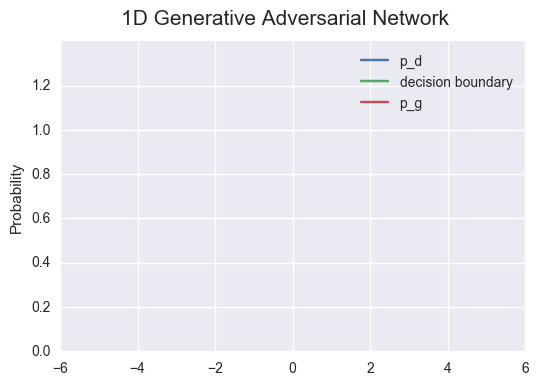

In [87]:

f, ax = plt.subplots(figsize=(6,4))
f.suptitle('1D Generative Adversarial Network', fontsize=15)
plt.ylabel('Probability')
ax.set_xlim(-6, 6)
ax.set_ylim(0, 1.4)
line_d, = ax.plot([], [], label='p_d')
line_ds, = ax.plot([], [], label='decision boundary')
line_g, = ax.plot([], [], label='p_g')
frame_text = ax.text(0.02, 0.95,'',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes)
ax.legend()


In [88]:
def init():
    line_d.set_data([],[])
    line_ds.set_data([],[])
    line_g.set_data([],[])
    frame_text.set_text('Start')
    return (line_d,) + (line_ds,) + (line_g,) + (frame_text,)

def animate(i):
    bins = np.linspace(-3, 5, 50)
    x = np.linspace(-3, 5, batch_size)
    
    histd, _ = np.histogram(anim_step[i]['real_data'], bins=bins, normed=True)
    line_d.set_data(bins[1:], histd)

    ds = anim_step[i]['decision_fake']
    line_ds.set_data(x, ds)
    
    histg, _ = np.histogram(anim_step[i]['output_g'], bins=bins, normed=True)
    line_g.set_data(bins[1:], histg)
    
    frame_text.set_text('Timestep = %.1d/%.1d' % (i, len(anim_step)))
    
    return (line_d,) + (line_ds,) + (line_g,) + (frame_text,)

anim = animation.FuncAnimation(f, animate, init_func=init,
                               frames=len(anim_step), blit=True)

HTML(anim.to_html5_video())

In [83]:
anim_step[0]

{'decision_fake': array([[ 0.7005465 ],
        [ 0.69908416],
        [ 0.69759327],
        [ 0.69607341],
        [ 0.69452387],
        [ 0.69294453],
        [ 0.69133478],
        [ 0.68969417],
        [ 0.68802226],
        [ 0.68631858],
        [ 0.68458283],
        [ 0.68281436],
        [ 0.68101299],
        [ 0.67917812],
        [ 0.67730951],
        [ 0.67540658],
        [ 0.67346907],
        [ 0.67149657],
        [ 0.66948885],
        [ 0.6674453 ],
        [ 0.66536576],
        [ 0.66324991],
        [ 0.66109753],
        [ 0.65890813],
        [ 0.6566816 ],
        [ 0.65441769],
        [ 0.65211624],
        [ 0.64977688],
        [ 0.64739972],
        [ 0.64498442],
        [ 0.64253098],
        [ 0.64003927],
        [ 0.63750923],
        [ 0.63494092],
        [ 0.63233435],
        [ 0.62968951],
        [ 0.62700665],
        [ 0.62428576],
        [ 0.62152702],
        [ 0.61873072],
        [ 0.61589718],
        [ 0.6130265 ],
        [ 0.61011